# Evaluation of Qwen2.5-VL-7B-Instruct in classifying Article Type and Base Color

Dataset used: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

### Notes:
* some of the articleType class only have a couple images associated. We will just evaluate on the more popular columns with at least 200 images. This ends up being **40 classes**.
* season is not refering to season that the clothing item should be worn, but rather when it was released, so I don't think it makes sense to evaluate on. Similarly for the 'usage' column, 77% is 'Casual', 9% is 'Sports, 14% is 'Other, so I don't think it is very valuable to evaluate on

## Imports

In [ ]:
%%capture
# Install required packages
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate
!pip install torch
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install scikit_learn
!pip install keras
!pip install tensorflow
!pip install huggingface_hub[hf_transfer]
!pip install qwen-vl-utils[decord]==0.0.8

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub

import os
import random
from PIL import Image
import tempfile
import requests
from io import BytesIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, confusion_matrix,roc_auc_score,recall_score,f1_score, ConfusionMatrixDisplay

import torch
from huggingface_hub import hf_hub_download, snapshot_download
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

## Download data and create subset for eval

In [ ]:
# download data to cache
kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

100%|██████████| 23.1G/23.1G [03:41<00:00, 112MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1'

In [ ]:
# view images.csv
images = pd.read_csv("/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset/images.csv")
images.head(10)

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...
5,1855.jpg,http://assets.myntassets.com/v1/images/style/p...
6,30805.jpg,http://assets.myntassets.com/v1/images/style/p...
7,26960.jpg,http://assets.myntassets.com/v1/images/style/p...
8,29114.jpg,http://assets.myntassets.com/v1/images/style/p...
9,30039.jpg,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
# view styles.csv
styles = pd.read_csv("/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset/styles.csv", on_bad_lines='skip')  # Skip lines with errors
styles.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


In [ ]:
# print number of unique values in articleType column in styles df
print(f"Total number of unique values in articleType: {styles['articleType'].nunique()}")

# Get value counts for 'articleType'
article_type_counts = styles['articleType'].value_counts()

# Filter for values with more than 200 samples
filtered_article_types = article_type_counts[article_type_counts > 200].index.tolist()

# Print the filtered list count
print(f"Number of unique values in articleType with more than 200 samples: {len(filtered_article_types)}")
print(filtered_article_types)

Total number of unique values in articleType: 143
Number of unique values in articleType with more than 200 samples: 40
['Tshirts', 'Shirts', 'Casual Shoes', 'Watches', 'Sports Shoes', 'Kurtas', 'Tops', 'Handbags', 'Heels', 'Sunglasses', 'Wallets', 'Flip Flops', 'Sandals', 'Briefs', 'Belts', 'Backpacks', 'Socks', 'Formal Shoes', 'Perfume and Body Mist', 'Jeans', 'Shorts', 'Trousers', 'Flats', 'Bra', 'Dresses', 'Sarees', 'Earrings', 'Deodorant', 'Nail Polish', 'Lipstick', 'Track Pants', 'Clutches', 'Sweatshirts', 'Caps', 'Sweaters', 'Ties', 'Jackets', 'Innerwear Vests', 'Kurtis', 'Tunics']


In [ ]:
# create subset of styles.csv, which only includes the articleTypes in filtered_article_types
styles_subset = styles[styles['articleType'].isin(filtered_article_types)]

# randomly select 200 rows for each filtered_article_types unique value from styles_subset
random.seed(42)
styles_subset = styles_subset.groupby('articleType').apply(lambda x: x.sample(200)).reset_index(drop=True)
styles_subset

<ipython-input-35-0d1a44759747>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  styles_subset = styles_subset.groupby('articleType').apply(lambda x: x.sample(200)).reset_index(drop=True)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,39510,Unisex,Accessories,Bags,Backpacks,Black,Summer,2012.0,Casual,Peter England Unisex Black Backpack
1,32869,Unisex,Accessories,Bags,Backpacks,Black,Summer,2015.0,Casual,Wildcraft Unisex Black & Grey Backpack
2,8516,Unisex,Accessories,Bags,Backpacks,Black,Summer,2011.0,Sports,Nike Unisex Ultimatum Max Black Backpacks
3,4685,Unisex,Accessories,Bags,Backpacks,Black,Summer,2011.0,Sports,ADIDAS BP Classic Black Unisex Backpack
4,39485,Unisex,Accessories,Bags,Backpacks,Green,Summer,2015.0,Casual,Wildcraft Unisex Green Hydrator Backpack
...,...,...,...,...,...,...,...,...,...,...
7995,45923,Women,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Maxima Women Black Dial Watch
7996,37480,Women,Accessories,Watches,Watches,White,Winter,2016.0,Casual,Esprit Women White Watch
7997,59254,Men,Accessories,Watches,Watches,White,Winter,2016.0,Casual,Titan Men White Dial Watch
7998,29934,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Police Women Silver-Toned Dial Watch PL12896BS...


### Save csv files if necessary

In [ ]:
# save styles_subset as csv into /content/drive/MyDrive/MIDS Capstone/styles_subset.csv
styles_subset.to_csv("/content/drive/MyDrive/MIDS Capstone/styles_subset.csv", index=False)

images.to_csv("/content/drive/MyDrive/MIDS Capstone/images.csv", index=False)

## Evaluate Qwen2.5-VL-7B on classifying articleType and baseColour

We will evaluate on the subset of 8000 images.

### Reload in csv files if necessary

In [ ]:
# load in styles_subset and images
styles_subset = pd.read_csv("/content/drive/MyDrive/MIDS Capstone/styles_subset.csv")
images = pd.read_csv("/content/drive/MyDrive/MIDS Capstone/images.csv")

In [ ]:
# check to make sure df is as expected
styles_subset.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,39510,Unisex,Accessories,Bags,Backpacks,Black,Summer,2012.0,Casual,Peter England Unisex Black Backpack
1,32869,Unisex,Accessories,Bags,Backpacks,Black,Summer,2015.0,Casual,Wildcraft Unisex Black & Grey Backpack
2,8516,Unisex,Accessories,Bags,Backpacks,Black,Summer,2011.0,Sports,Nike Unisex Ultimatum Max Black Backpacks
3,4685,Unisex,Accessories,Bags,Backpacks,Black,Summer,2011.0,Sports,ADIDAS BP Classic Black Unisex Backpack
4,39485,Unisex,Accessories,Bags,Backpacks,Green,Summer,2015.0,Casual,Wildcraft Unisex Green Hydrator Backpack


In [ ]:
images.head(5)

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


#### Get Model

In [ ]:
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'

# Define the model repository ID
repo_id = "Qwen/Qwen2.5-VL-7B-Instruct"

# Download the model file using hf_transfer
file_path = snapshot_download(repo_id)

print(f"Model downloaded to: {file_path}")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-VL-7B-Instruct/snapshots/41bf8b5ecf63c81d5e5f5932693663ac4b5c4595


In [ ]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# define prompt string
filtered_article_types = ['Tshirts', 'Shirts', 'Casual Shoes', 'Watches', 'Sports Shoes', 'Kurtas', 'Tops', 'Handbags', 'Heels', 'Sunglasses', 'Wallets', 'Flip Flops', 'Sandals', 'Briefs', 'Belts', 'Backpacks', 'Socks', 'Formal Shoes', 'Perfume and Body Mist', 'Jeans', 'Shorts', 'Trousers', 'Flats', 'Bra', 'Dresses', 'Sarees', 'Earrings', 'Deodorant', 'Nail Polish', 'Lipstick', 'Track Pants', 'Clutches', 'Sweatshirts', 'Caps', 'Sweaters', 'Ties', 'Jackets', 'Innerwear Vests', 'Kurtis', 'Tunics']
article_type_labels_str = ", ".join(filtered_article_types)
prompt = f"Classify this image as one of the following: {article_type_labels_str}. Answer with only the label name."
print(prompt)

Classify this image as one of the following: Tshirts, Shirts, Casual Shoes, Watches, Sports Shoes, Kurtas, Tops, Handbags, Heels, Sunglasses, Wallets, Flip Flops, Sandals, Briefs, Belts, Backpacks, Socks, Formal Shoes, Perfume and Body Mist, Jeans, Shorts, Trousers, Flats, Bra, Dresses, Sarees, Earrings, Deodorant, Nail Polish, Lipstick, Track Pants, Clutches, Sweatshirts, Caps, Sweaters, Ties, Jackets, Innerwear Vests, Kurtis, Tunics. Answer with only the label name.


In [ ]:
styles_subset.iloc[0]["id"]

39510

### Test on first row (it is a backpack)

In [ ]:
# Get the desired filename
first_filename = str(styles_subset.iloc[0]["id"]) + ".jpg"  # Using iloc for index-based access

# Find the row in 'images' DataFrame where 'filename' matches
first_link_value = images.loc[images['filename'] == first_filename, 'link'].iloc[0]

# Print the link value
print(first_link_value)

http://assets.myntassets.com/v1/images/style/properties/Peter-England-Unisex-Black-Backpack_714246d01bd165fba311d87e2c0aa6bc_images.jpg


In [ ]:
# define message with first image and prompt
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": first_link_value,
            },
            {"type": "text", "text": prompt},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['Backpacks']


### Evaluate on full subset
Resized the images from 1,800 x 2,400 to 450 x 600 before evaluate due to gpu memory constraints

In [ ]:
# took ~ 53min on A100
true_labels = []
pred_labels = []

for index, row in styles_subset.iterrows():
  filename = str(row["id"]) + ".jpg"
  image_link = images.loc[images['filename'] == filename, 'link'].iloc[0]

  # Open the image
  response = requests.get(image_link)
  img = Image.open(BytesIO(response.content))

  # Get original dimensions
  width, height = img.size

  # Calculate new dimensions (quarter size)
  new_width = width // 4
  new_height = height // 4

  # Resize the image
  resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

  # Create a temporary file path
  temp_path = os.path.join(tempfile.gettempdir(), 'resized_image.jpg')

  # Save the resized image to temp path
  resized_img.save(temp_path)

  # define message with image and prompt
  messages = [
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": temp_path,
              },
              {"type": "text", "text": prompt},
          ],
      }
  ]

  # Preparation for inference
  text = processor.apply_chat_template(
      messages, tokenize=False, add_generation_prompt=True
  )
  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor(
      text=[text],
      images=image_inputs,
      videos=video_inputs,
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to("cuda")

  # Inference: Generation of the output
  generated_ids = model.generate(**inputs, max_new_tokens=128)
  generated_ids_trimmed = [
      out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
  )

  # save output
  pred_labels.append(output_text[0])
  true_labels.append(row["articleType"])
  os.remove(temp_path)


Number of Validation Samples: 8000
Accuracy: 0.825125


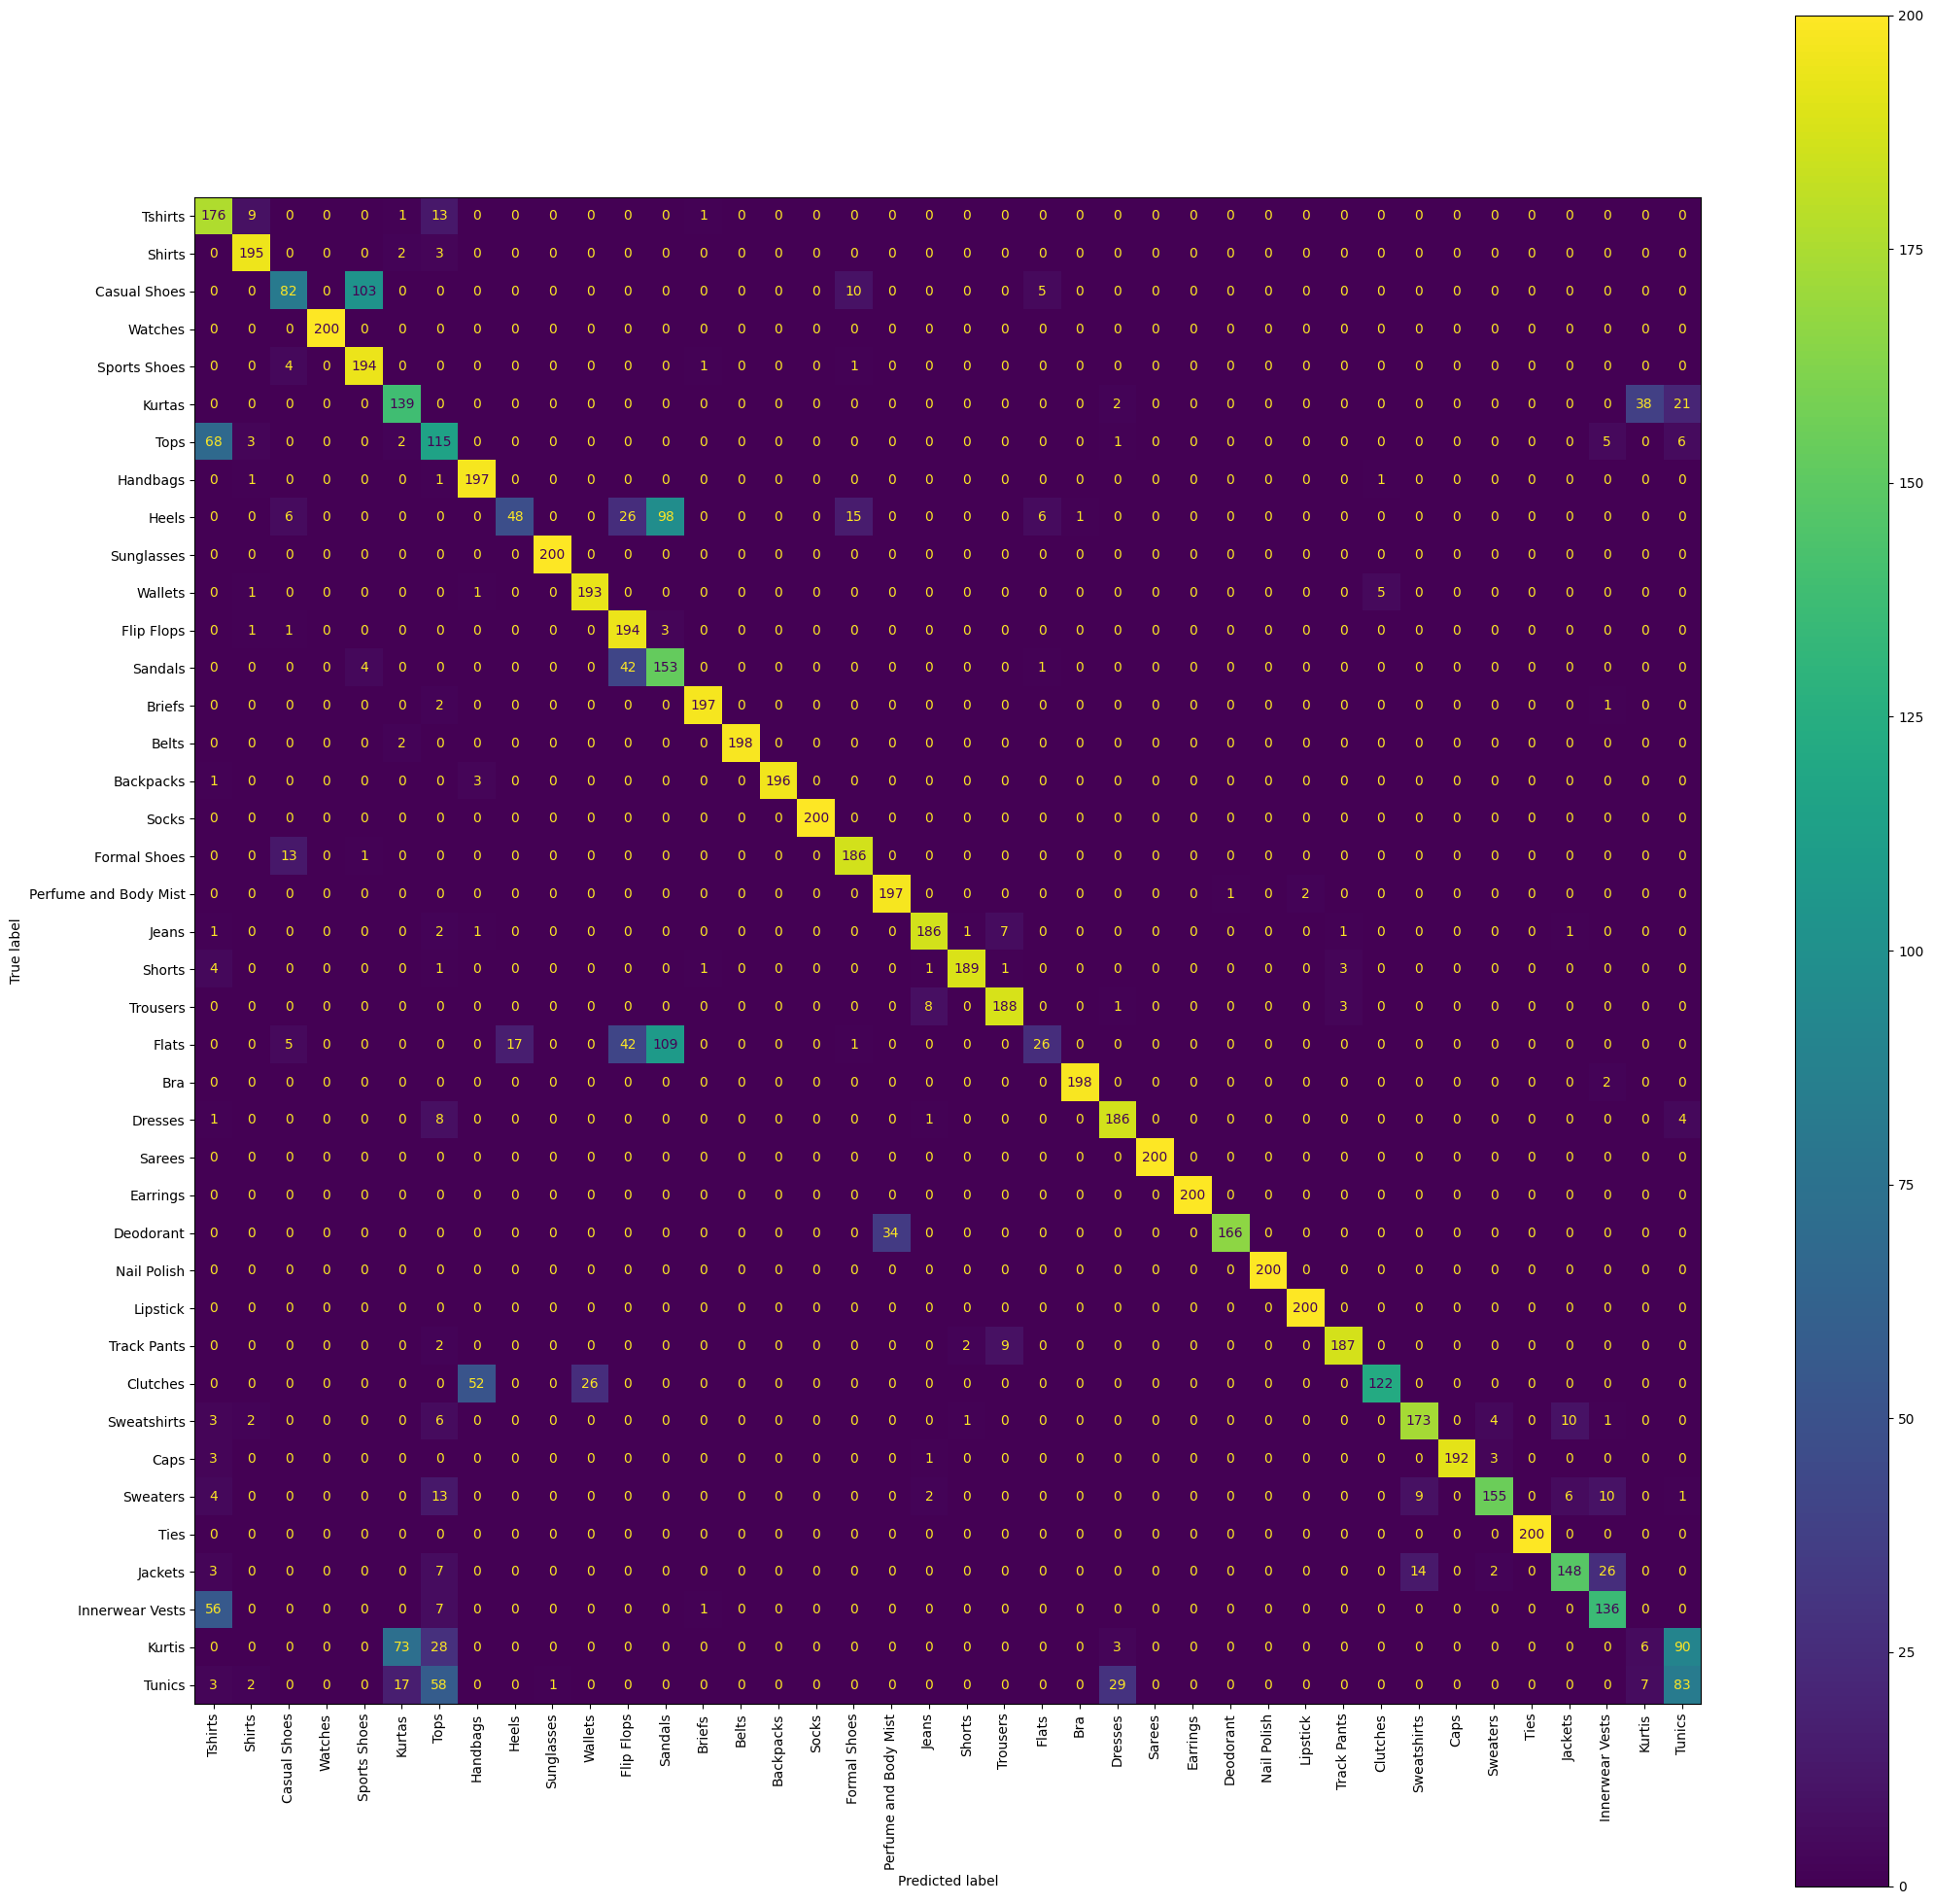

In [ ]:
# compute metrics and confusion matrix
def eval_model(preds, true_labels, display_labels):
    print("Accuracy: " + str(sum(1 for x, y in zip(preds, true_labels) if x == y) / len(true_labels)))

    cm = confusion_matrix(true_labels, preds, labels=display_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot()
    plt.xticks(rotation=90)
    # increase plot size
    plt.rcParams["figure.figsize"] = (25,25)
    plt.show()

print("Number of Validation Samples: " + str(len(true_labels)))
eval_model(pred_labels, true_labels, filtered_article_types)

#### Observations
* misclassifies casual shoes as sport shoes
* misclassifies tunics as tops
* misclassfies flats and heels as sandals
* struggles mostly on the categories that have overlaps e.g. sport shoes could be a casual shoe too, or clutches as handbags

In [ ]:
# save pred_labels, true_labels as string in /content/drive/MyDrive/MIDS Capstone
np.savetxt("/content/drive/MyDrive/MIDS Capstone/pred_labels.txt", pred_labels, fmt="%s")
np.savetxt("/content/drive/MyDrive/MIDS Capstone/true_labels.txt", true_labels, fmt="%s")

In [ ]:
# read in pred_labels, true_labels back into lists
pred_labels = []
true_labels = []

with open('/content/drive/MyDrive/MIDS Capstone/pred_labels.txt', 'r') as file:
    pred_labels = [line.strip() for line in file]

with open('/content/drive/MyDrive/MIDS Capstone/true_labels.txt', 'r') as file:
    true_labels = [line.strip() for line in file]

print(f"Count of pred_labels: {len(pred_labels)}")
print(f"Count of true_labels: {len(true_labels)}")

Count of pred_labels: 8000
Count of true_labels: 8000


## Evaluate on color column

### Test on first image (black)

In [ ]:
# define prompt string
styles_subset["baseColour"] = styles_subset["baseColour"].astype(str)
color_vals = styles_subset["baseColour"].unique()
color_labels_str = ", ".join(color_vals)
color_prompt = f"Classify the main color of the item in the image as one of the following: {color_labels_str}. Answer with only the label name."
print(color_prompt)

Classify the main color of the item in the image as one of the following: Black, Green, Red, Orange, Grey, Beige, Blue, Navy Blue, Yellow, Brown, Purple, Olive, Mustard, Pink, Charcoal, White, Tan, Peach, Gold, Silver, Teal, Maroon, Multi, Cream, Skin, Rose, Lavender, Grey Melange, Turquoise Blue, Nude, Khaki, Burgundy, Magenta, Copper, Off White, Metallic, Bronze, Coffee Brown, Sea Green, Mushroom Brown, nan, Mauve, Rust, Steel. Answer with only the label name.


In [ ]:
# define message with first image and prompt
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": first_link_value,
            },
            {"type": "text", "text": color_prompt},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['Black']


### Evaluate on full set

In [ ]:
# took ~ 52min on A100
color_true_labels = []
color_pred_labels = []

for index, row in styles_subset.iterrows():
  filename = str(row["id"]) + ".jpg"
  image_link = images.loc[images['filename'] == filename, 'link'].iloc[0]

  # Open the image
  response = requests.get(image_link)
  img = Image.open(BytesIO(response.content))

  # Get original dimensions
  width, height = img.size

  # Calculate new dimensions (quarter size)
  new_width = width // 4
  new_height = height // 4

  # Resize the image
  resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

  # Create a temporary file path
  temp_path = os.path.join(tempfile.gettempdir(), 'resized_image.jpg')

  # Save the resized image to temp path
  resized_img.save(temp_path)

  # define message with image and prompt
  messages = [
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": temp_path,
              },
              {"type": "text", "text": color_prompt},
          ],
      }
  ]

  # Preparation for inference
  text = processor.apply_chat_template(
      messages, tokenize=False, add_generation_prompt=True
  )
  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor(
      text=[text],
      images=image_inputs,
      videos=video_inputs,
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to("cuda")

  # Inference: Generation of the output
  generated_ids = model.generate(**inputs, max_new_tokens=128)
  generated_ids_trimmed = [
      out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
  )

  # save output
  color_pred_labels.append(output_text[0])
  color_true_labels.append(row["baseColour"])
  os.remove(temp_path)


Number of Validation Samples: 8000
Accuracy: 0.616625


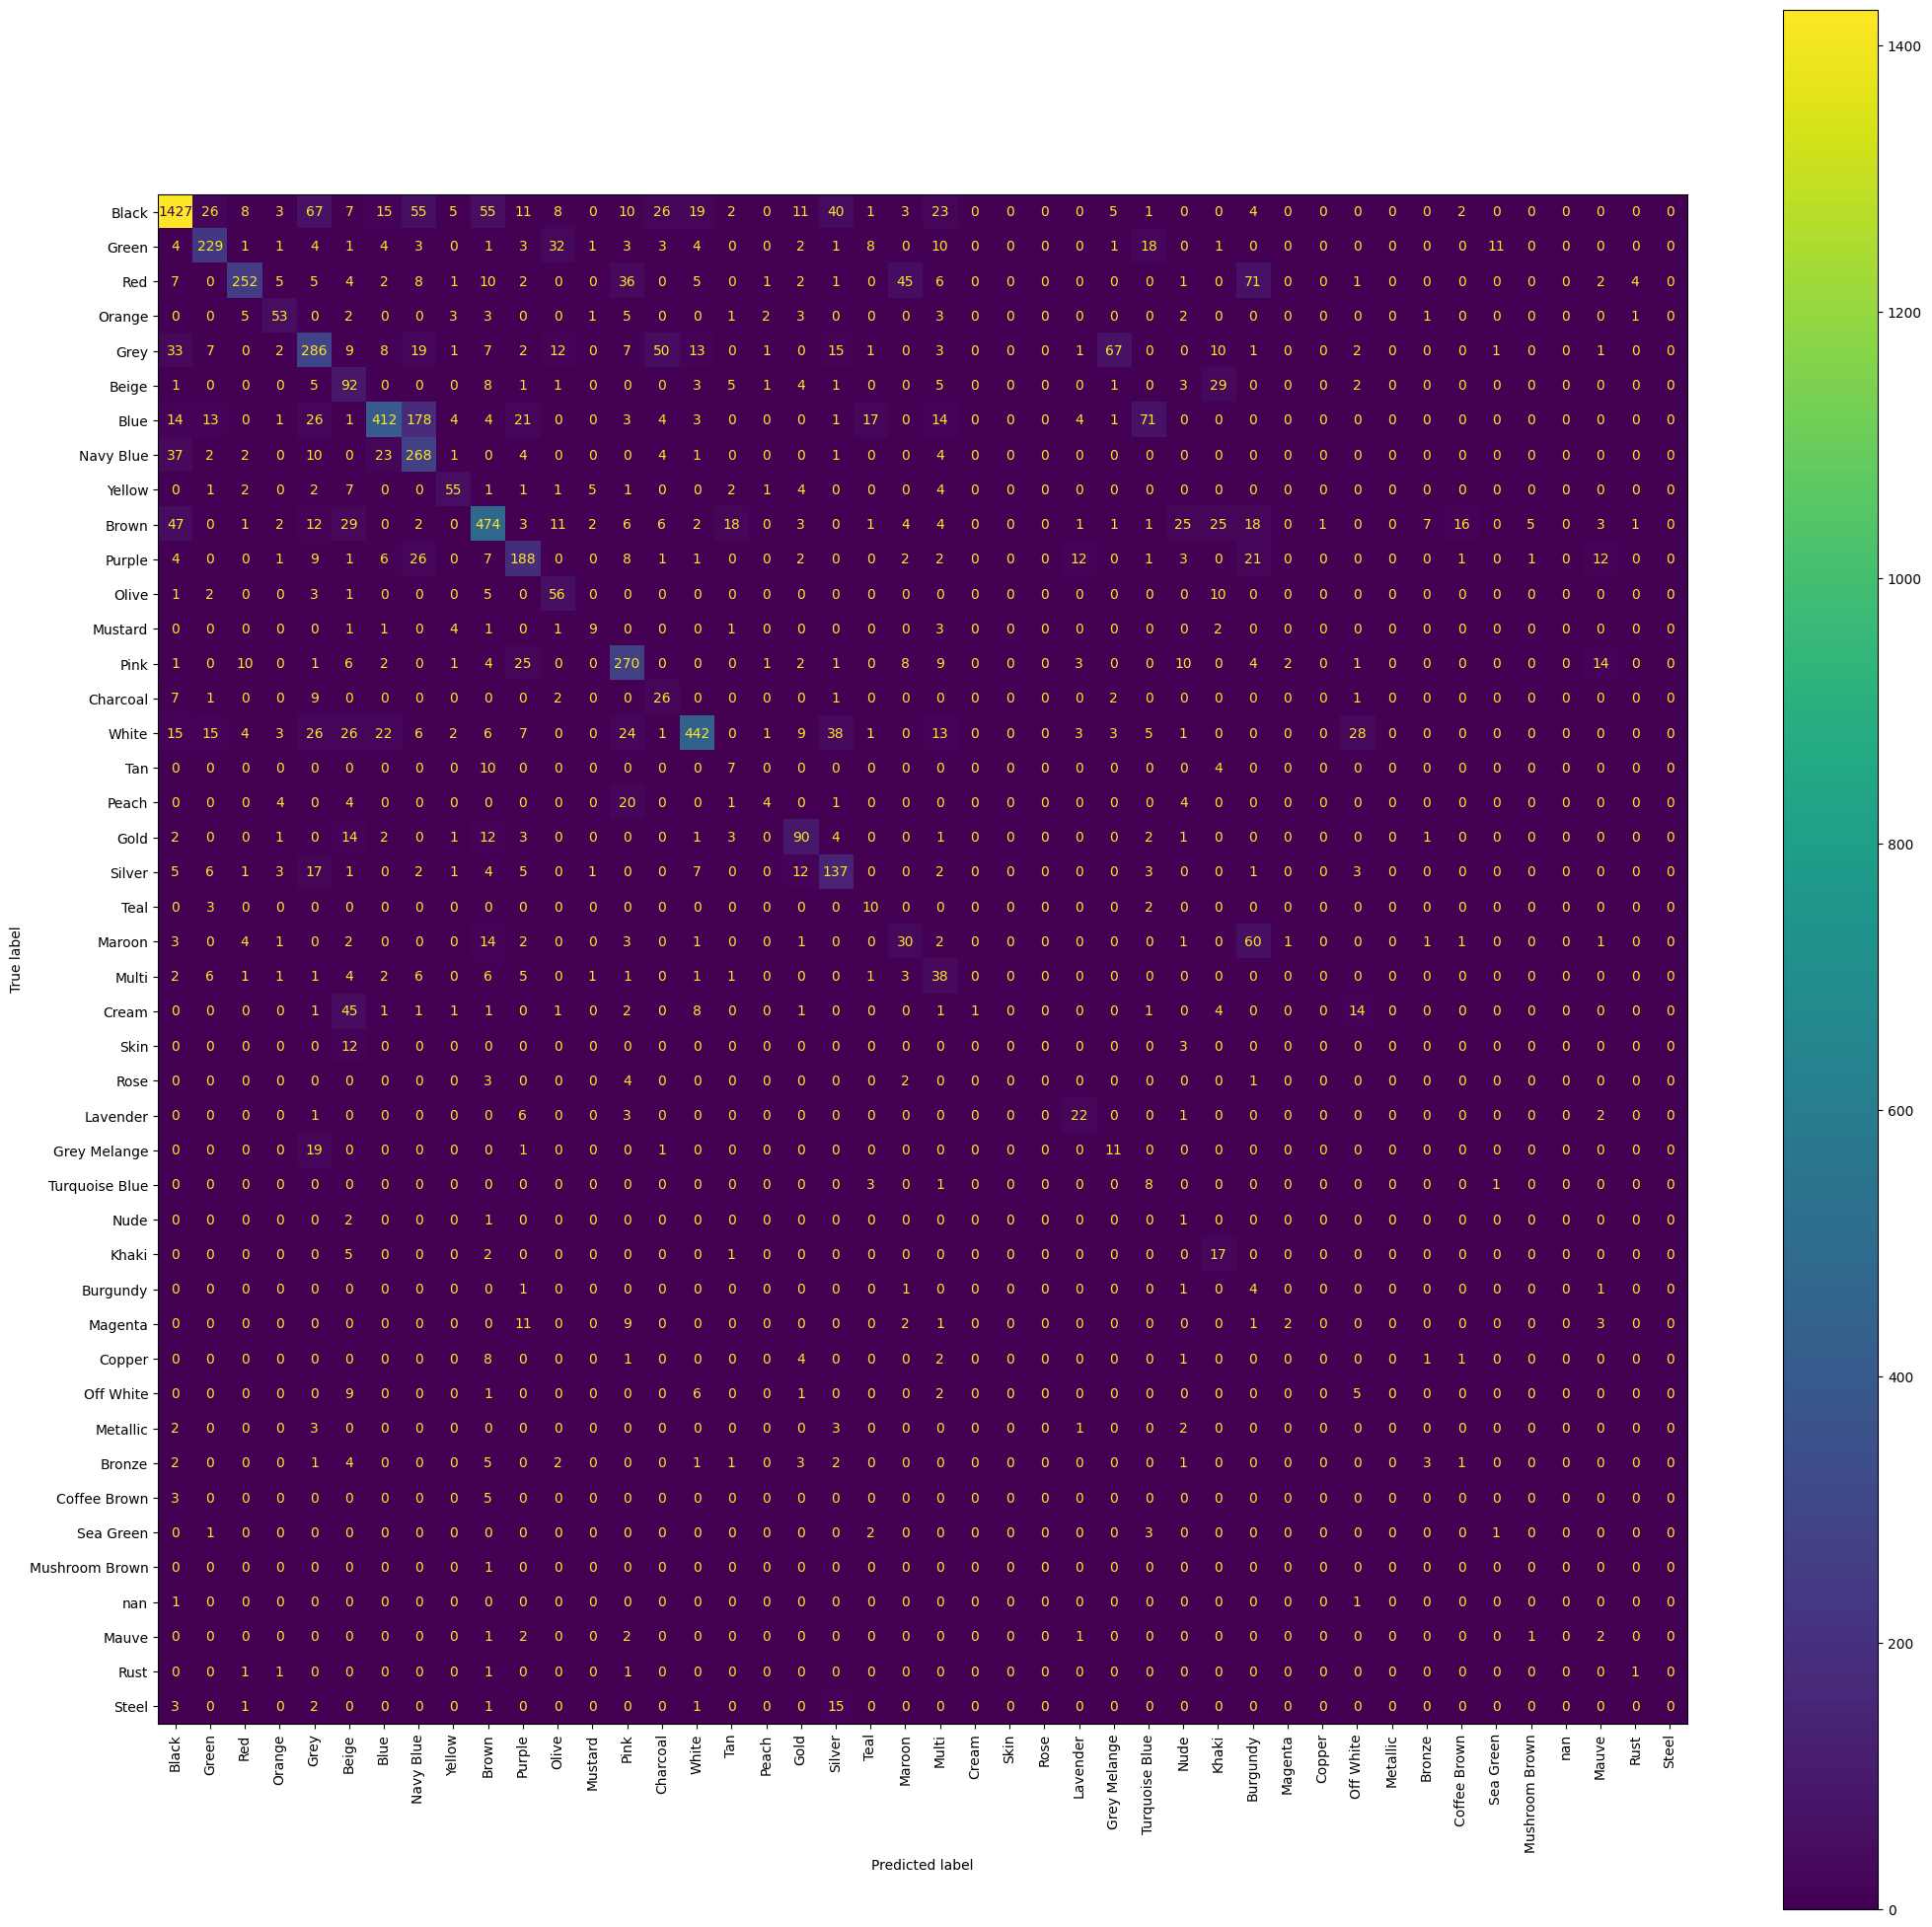

In [ ]:
# eval prediction on color
print("Number of Validation Samples: " + str(len(true_labels)))
eval_model(color_pred_labels, color_true_labels, color_vals)